In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.neighbors import KDTree

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 50

import src

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
train_models = src.shapenet.get_shapenet_data("val")
ppfnet = src.pointnet.PPFNet()
ppfnet.model.load_weights("models/sun_trained_10.tf")

In [3]:
nb_points = 100000
nb_patches=2048
nb_points_per_patches = 1024

#path = np.random.choice(train_models)
path = 'data/ShapeNetCore.v2/02691156/973211dfe6bcc4ae90b1d6deb98feec6/models/model_normalized.obj'
cloud = src.shapenet.sample_points(path , nb=nb_points)
extractor = src.dataset.PPFPatchExtractor(nb_patches=nb_patches, nb_points=nb_points_per_patches)
centers, centers_normals, patches, patches_normals, centers_idx = extractor.make_patches(cloud)
ppf = extractor.compute_ppf(centers, centers_normals, patches, patches_normals).astype(np.float32)
M = extractor.compute_M(centers)

0.68310546875


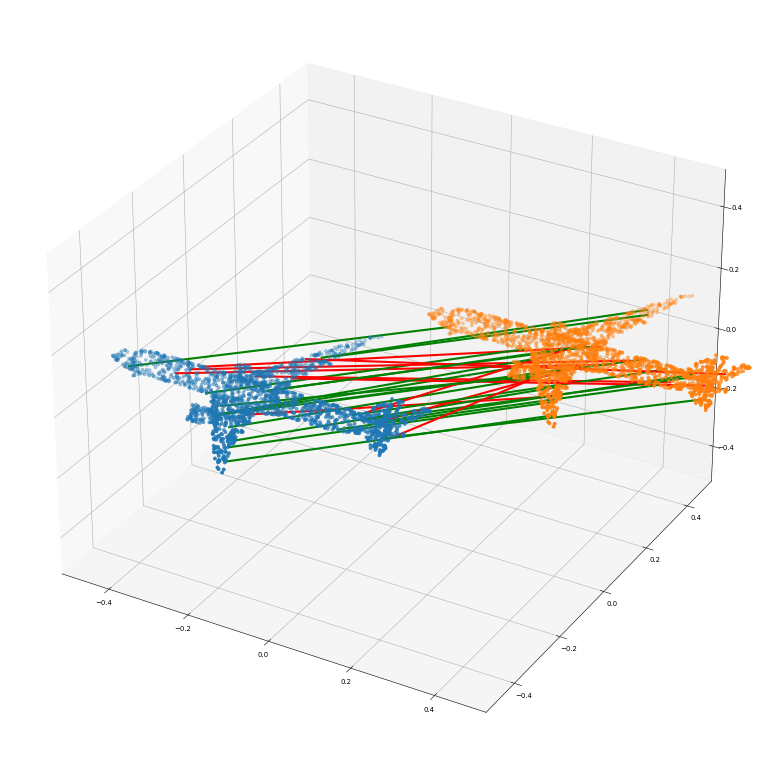

In [4]:
pred = ppfnet.model(ppf[np.newaxis])
diff = pred[:,:,tf.newaxis] - pred[:,tf.newaxis] # (N, nb_patches, nb_patches, features)
D = tf.reduce_sum(diff*diff, axis=-1) # (N, nb_patches, nb_patches)

matches = np.argsort(D[0].numpy(), axis=0)[1]

nb_matches = 30
centers_idx_np = centers_idx
idx_start = centers_idx_np
idx_end = matches
idx_end = centers_idx_np[idx_end]


cloud_np = cloud[0]
pos_start = cloud_np[idx_start]
pos_end = cloud_np[idx_end]

dist_match = np.linalg.norm(pos_start-pos_end, axis=1)
good_match = dist_match < extractor.tau
match_colors = np.array(["red", "green"])[good_match.astype(np.int)]

print(good_match.mean())

delta = np.array([0.25, 0,0.25])
curves = np.stack([pos_start - delta, pos_end + delta], axis=1)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')

n= 2000
xs = cloud_np[:n,2]
ys = cloud_np[:n,0]
zs = cloud_np[:n,1]

lim = (-0.5,0.5)

ax.set_xlim(lim)
ax.set_ylim(lim) 
ax.set_zlim(lim) 

ax.scatter(xs-0.25, ys-0.25, zs)
ax.scatter(xs+0.25, ys+0.25, zs)
for i in range(nb_matches):
    ax.plot(curves[:,:,2][i], curves[:,:,0][i], curves[:,:,1][i],linewidth=3, color=match_colors[i])

plt.show()

In [5]:
#patch_idx = np.random.randint(len(ppf))
patch_idx = np.argmin(centers[:,1])

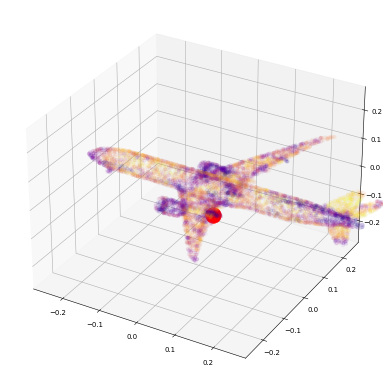

In [6]:
pred = ppfnet.model(ppf[np.newaxis])
diff = pred[0,:,tf.newaxis] - pred[0,tf.newaxis] # (N, nb_patches, nb_patches, features)
D = tf.reduce_sum(diff*diff, axis=-1) # (N, nb_patches, nb_patches)

cloud_pos = cloud[0]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')



#Point cloud of the model

kdt = KDTree(centers)
neighbors = kdt.query(cloud_pos, k=3, return_distance=False)
values = D[patch_idx].numpy()[neighbors].mean(axis=-1)

src.utils.export_ply("output/similarity.ply", cloud_pos, normals=cloud[1], scalar=np.max(values) - values)
src.utils.export_ply("output/patche.ply", patches[patch_idx])

n_points = 10000
values = values[:n_points]
xs = cloud_pos[:n_points,2]
ys = cloud_pos[:n_points,0]
zs = cloud_pos[:n_points,1]

lim = (-0.27,0.27)

ax.set_xlim(lim)
ax.set_ylim(lim) 
ax.set_zlim(lim) 


cmap = plt.get_cmap("plasma")
colors = cmap(np.linspace(0,1,n_points)[np.argsort(np.argsort(values))])
ax.scatter(xs, ys, zs, alpha=0.05, color=colors)

#Center of chosen patch

xs = centers[patch_idx,2]
ys = centers[patch_idx,0]
zs = centers[patch_idx,1]

ax.scatter(xs, ys, zs, color="red", s=500)
plt.show()

In [7]:
def extract_frame():
    cloud = src.shapenet.sample_points(path , nb=nb_points)
    centers, centers_normals, patches, patches_normals, centers_idx = extractor.make_patches(cloud)
    ppf = extractor.compute_ppf(centers, centers_normals, patches, patches_normals).astype(np.float32)
    return cloud, centers, centers_normals, patches, patches_normals, centers_idx, ppf

extrated_frame_a = extract_frame()
extrated_frame_b = extract_frame()
M = extractor.compute_M_pair(extrated_frame_a[1], extrated_frame_b[1])

pred_a = ppfnet.model(extrated_frame_a[-1][np.newaxis])
pred_b = ppfnet.model(extrated_frame_b[-1][np.newaxis])
diff = pred_a[0,:,tf.newaxis] - pred_b[0,tf.newaxis]
D = tf.reduce_sum(diff*diff, axis=-1).numpy()

0.6572265625


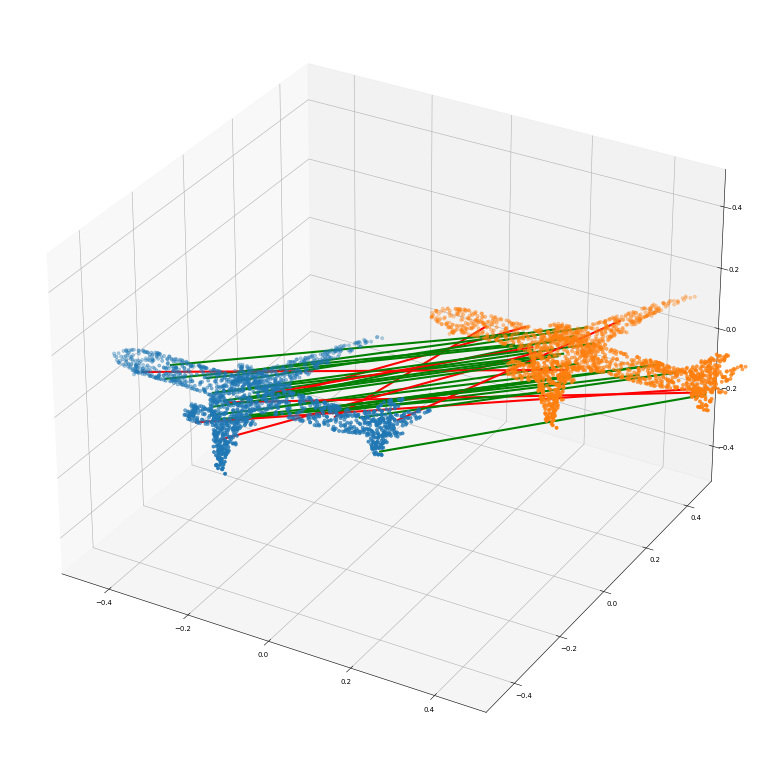

In [8]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')

lim = (-0.5,0.5)

ax.set_xlim(lim)
ax.set_ylim(lim) 
ax.set_zlim(lim) 

def plot_cloud(ax, cloud, max_points=2000):
    if len(cloud) > max_points:
        idx = np.random.choice(len(cloud), max_points)
    xs = cloud[idx,2]
    ys = cloud[idx,0]
    zs = cloud[idx,1]
        
    ax.scatter(xs, ys, zs)
    
    
delta = np.array([1,0,1])*0.25
plot_cloud(ax, extrated_frame_a[0][0] - delta)  
plot_cloud(ax, extrated_frame_b[0][0] + delta)  

nb_matches = 30
matches_start_idx = np.where(M.any(axis=1))
matches_end_idx = np.argmin(D[matches_start_idx], axis=1)
pos_start = extrated_frame_a[1][matches_start_idx]
pos_end = extrated_frame_b[1][matches_end_idx]

dist_match = np.linalg.norm(pos_start-pos_end, axis=1)
good_match = dist_match < extractor.tau
match_colors = np.array(["red", "green"])[good_match.astype(np.int)]
curves = np.stack([pos_start - delta, pos_end + delta], axis=1)

print(good_match.mean())

for i in range(nb_matches):
    ax.plot(curves[i,:,2], curves[i,:,0], curves[i,:,1],linewidth=3, color=match_colors[i])


### Sun3d dataset

In [9]:
import glob
import os
import pickle

scene_path = src.threeDMatch.get_sun3d_scenes(split="test")[0]
scene_frames = glob.glob(os.path.join(scene_path, "seq-01", "*.depth.png"))

In [10]:
gen = src.threeDMatch.gen_scene_couple(scene_path, "data/preprocessed-sun3d")

In [11]:
frame_a, frame_b = next(gen)

extractor = src.dataset.PPFPatchExtractor(nb_patches=nb_patches, nb_points=nb_points_per_patches, tau=0.1)
 
def extract_frame(frame, nb_points = 30000):
    cloud, colors = src.threeDMatch.get_cloud(frame, return_color=True)
    idx = np.random.choice(len(cloud), nb_points)
    cloud = cloud[idx], src.threeDMatch.get_normals(cloud, idx=idx)
    colors = colors[idx]
    centers, centers_normals, patches, patches_normals, centers_idx = extractor.make_patches(cloud)
    ppf = extractor.compute_ppf(centers, centers_normals, patches, patches_normals).astype(np.float32)
    return cloud, colors, centers, centers_normals, patches, patches_normals, centers_idx, ppf

extrated_frame_a = extract_frame(frame_a)
extrated_frame_b = extract_frame(frame_b)
M = extractor.compute_M_pair(extrated_frame_a[2], extrated_frame_b[2])

In [18]:
pred_a = ppfnet.model(extrated_frame_a[-1][np.newaxis])
pred_b = ppfnet.model(extrated_frame_b[-1][np.newaxis])
diff = pred_a[0,:,tf.newaxis] - pred_b[0,tf.newaxis]
D = tf.reduce_sum(diff*diff, axis=-1).numpy()
#D = -M.astype(np.float)

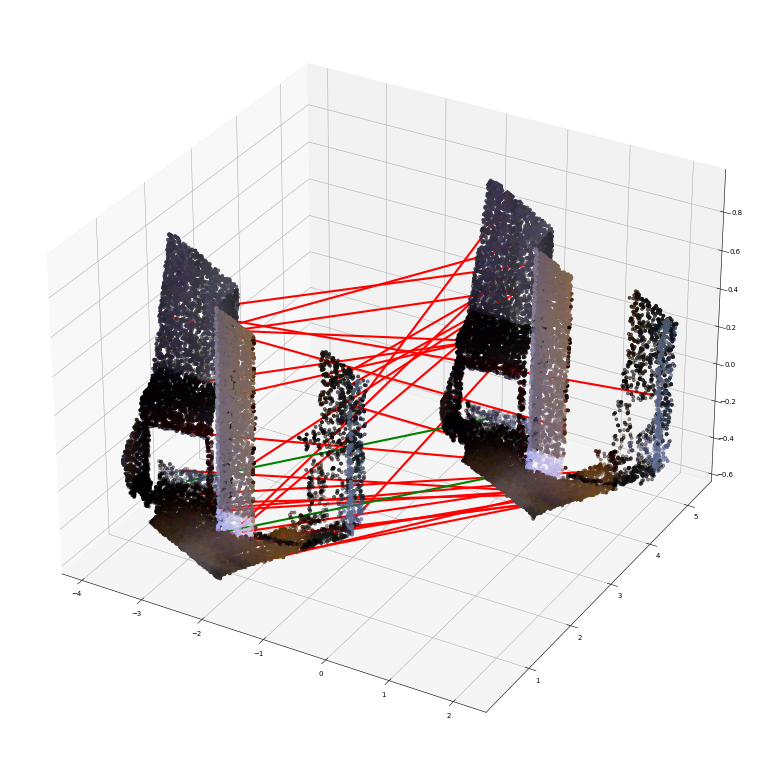

In [19]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')
# lim = (-5,5)
# ax.set_xlim(lim)
# ax.set_ylim(lim) 
# ax.set_zlim(lim) 

def plot_cloud(ax, cloud, colors=None, max_points=20000):
    if len(cloud) > max_points:
        idx = np.random.choice(len(cloud), max_points)
        cloud = cloud[idx]
        if colors is not None:
            colors = colors[idx]
    xs = cloud[:,2]
    ys = cloud[:,0]
    zs = cloud[:,1]
    if colors is not None:
        colors = colors/256
        
    ax.scatter(xs, ys, zs, color=colors)
    
    
delta = np.array([1,0,1])*1.5
plot_cloud(ax, extrated_frame_a[0][0] - delta, extrated_frame_a[1])  
plot_cloud(ax, extrated_frame_b[0][0] + delta, extrated_frame_b[1])  

nb_matches = 30
matches_start_idx = np.where(M.any(axis=1))[:nb_matches]
matches_end_idx = np.argmin(D[matches_start_idx], axis=1)
pos_start = extrated_frame_a[2][matches_start_idx]
pos_end = extrated_frame_b[2][matches_end_idx]

dist_match = np.linalg.norm(pos_start-pos_end, axis=1)
good_match = dist_match < extractor.tau
match_colors = np.array(["red", "green"])[good_match.astype(np.int)]
curves = np.stack([pos_start - delta, pos_end + delta], axis=1)

centers_idx_np = centers_idx
idx_start = np.arange(nb_matches)
idx_start = centers_idx_np[idx_start]
idx_end = matches[:nb_matches]
idx_end = centers_idx_np[idx_end]

for i in range(nb_matches):
    ax.plot(curves[i,:,2], curves[i,:,0], curves[i,:,1],linewidth=3, color=match_colors[i])
